<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/DepthWise_Separable_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depthwise Separable Convolution 

## Introduction

Depthwise Separable Convolution is a convolutional technique used in convolutional neural networks to reduce the number of parameters of the model and improve computational performance.

In this notebook, we will use this technique to train our CNN and compare the results with the previous models we have built. Before that, let us explain what Depthwise Separable Convolution is and why it allows us to achieve better computational performance.

## How it works

While standard convolution performs the channelwise and spatial-wise computation in one step, Depthwise Separable Convolution splits the computation into two steps: depthwise convolution applies a single convolutional filter per each input channel and pointwise convolution is used to create a linear combination of the output of the depthwise convolution.

So, the Depthwise Separable Convolution deals with not only the spatial dimensions but also the depth dimension, which refers to the number of channels in an image. An input image may have 3 channels representing RGB colors, but after passing through a few convolutional layers, it may have multiple channels. Each channel can be thought of as a particular interpretation of the image. For example, the "red" channel interprets the "redness" of each pixel, the "blue" channel interprets the "blueness" of each pixel, and the "green" channel interprets the "greenness" of each pixel. An image with 64 channels has 64 different interpretations of that image.

Below you can see an example of depthwise convolution along one dimension.

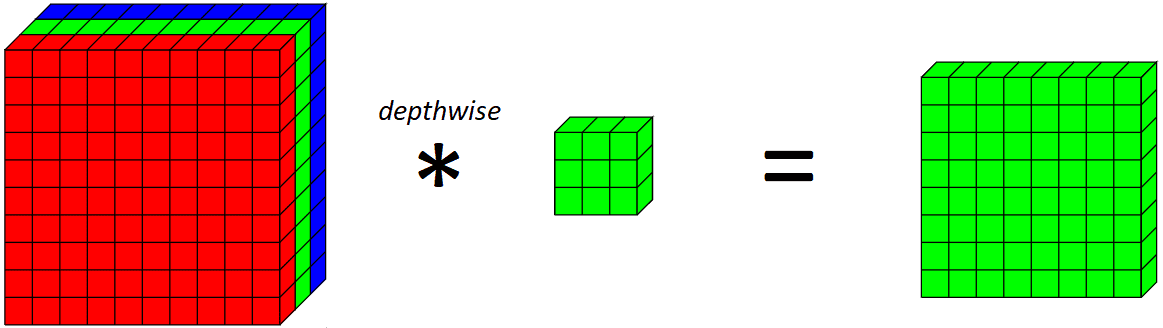

This operation must be applied to all dimensions of the image (e.g., height, width, and depth).
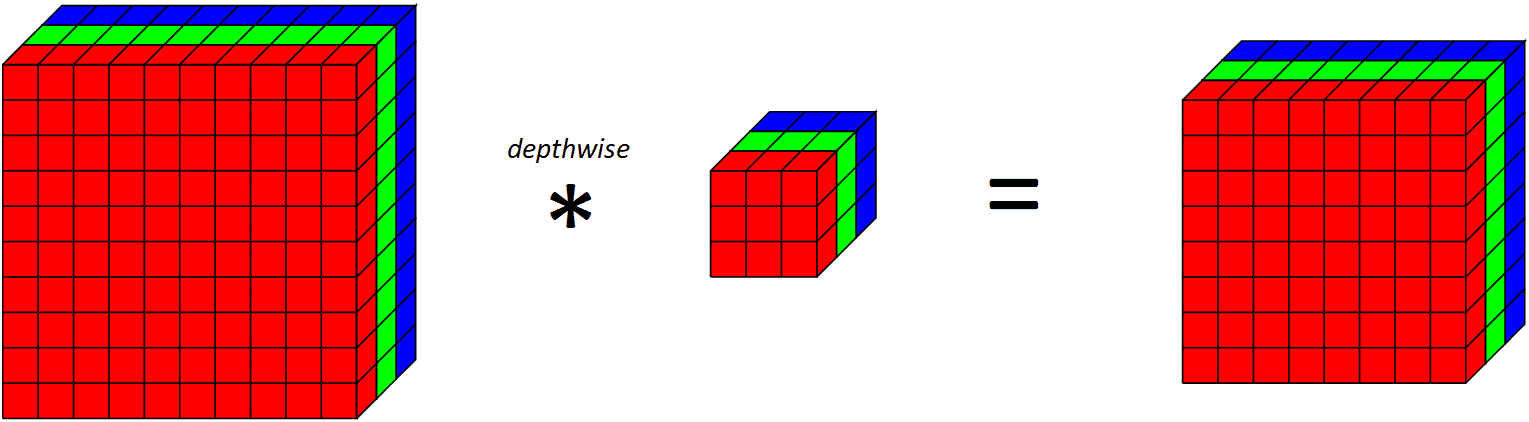

Once the convolution operation has been performed for all dimensions of the image, a pointwise convolution can be performed to aggregate the results into a single output. This involves computing the element-wise sum of the outputs for each channel of the image, resulting in a single output value.

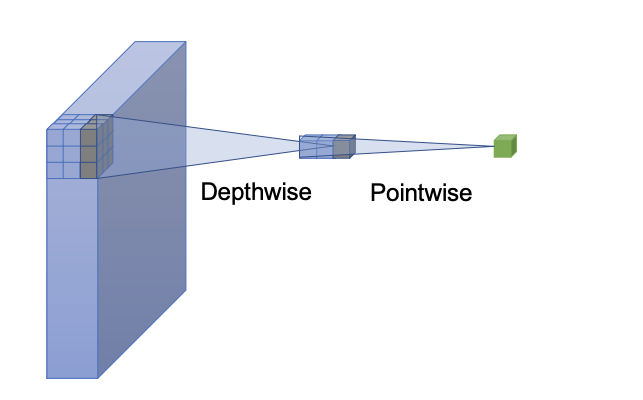

##Why using this technique?

These type of CNN’s are widely used because of the following two reasons –

* They have lesser number of parameters to adjust as compared to the standard CNN’s, which reduces overfitting
* They are computationally cheaper because of fewer computations which makes them suitable for mobile vision applications


#Setup

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

Our dataset contains images of various sizes. To ensure consistent inputs for the CNN, we need to resize the images to a standard size. 

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42


In the chart above, we can see that the most popular image size in the dataset is 181x181. We therefore decided to set the IMAGE_WIDTH and IMAGE_HEIGHT variables with the most common values.

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

  # ROC curve
  '''fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()'''

# Implementation 

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])


Loading of the best model defined from scratch in the previous notebook.

In [ ]:
model_name = 'TwoDropout128Dense/TwoDropout128Dense.h5'
model = tf.keras.models.load_model(os.path.join(models_path, model_name))
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                      

Our goal is to use the structure of this CNN and replace the Conv2D layers with SeparableConv2D layers, and then compare the results.

## Model definition

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d (Separable  (None, 224, 224, 32)     155       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 56, 56, 64)       2400      
 leConv2D)                                                       
                                                             

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0790 - accuracy: 0.1568
Epoch 1: val_loss improved from inf to 2.07675, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv/depthwise_separable_conv.h5
55/55 [==============================] - 33s 308ms/step - loss: 2.0790 - accuracy: 0.1568 - val_loss: 2.0767 - val_accuracy: 0.2733
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0643 - accuracy: 0.2210
Epoch 2: val_loss improved from 2.07675 to 2.01670, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv/depthwise_separable_conv.h5
55/55 [==============================] - 19s 307ms/step - loss: 2.0643 - accuracy: 0.2210 - val_loss: 2.0167 - val_accuracy: 0.3704
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.9525 - accuracy: 0.2464
Epoch 3: val_loss improved from 2.01670 to 1.84502, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv/dep

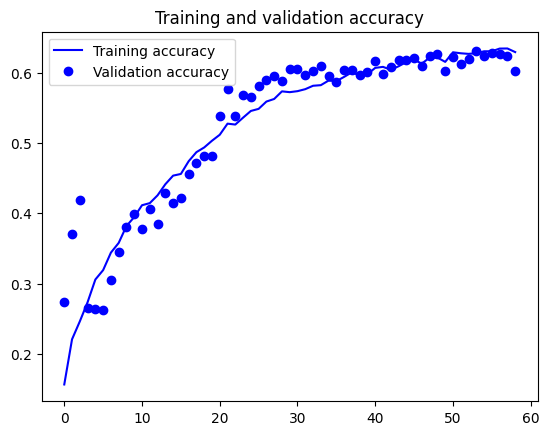

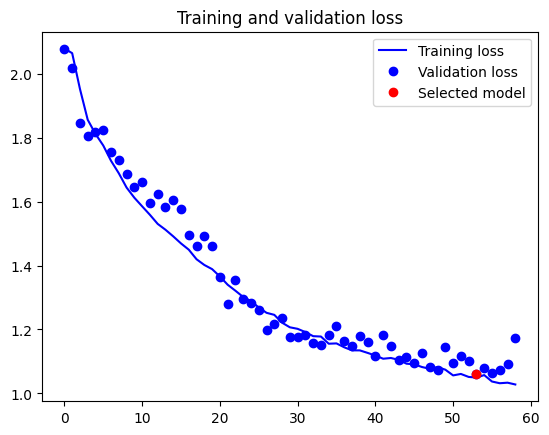

Lowest validation loss has been reached at epoch 53 with validation accuracy of 0.631


In [ ]:
model_name = "depthwise_separable_conv"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 176ms/step - loss: 1.0248 - accuracy: 0.6508
Test accuracy: 0.651, test loss: 1.025
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1401    0.8299    0.2397       147
           1     0.9683    0.6313    0.7643      1112
           2     0.8033    0.3391    0.4769       289
           3     0.4074    0.2245    0.2895        98
           4     0.6140    0.6364    0.6250       165
           5     0.6681    0.5312    0.5919       288
           6     0.6491    0.2824    0.3936       131
           7     0.5657    0.5714    0.5685        98

    accuracy                         0.5563      2328
   macro avg     0.6020    0.5058    0.4937      2328
weighted avg     0.7747    0.5563    0.6152      2328



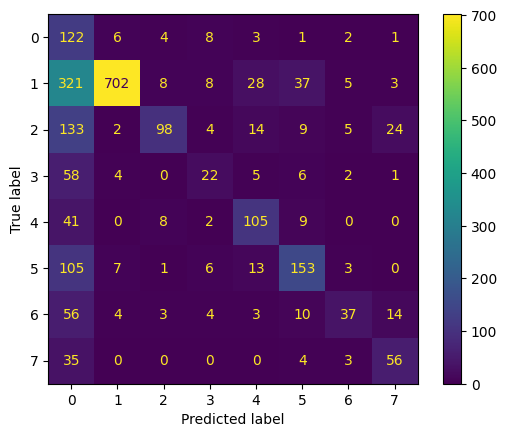

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

The results demonstrate that separable depthwise convolution is less powerful than normal convolution because, as explained above, it separates the convolution operation into two distinct parts. This separation can limit the network's ability to model complex relationships between different input channels; however, the complexity of the network has decreased considerably.

#Deeper Network

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, depth_multiplier=2, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 separable_conv2d_12 (Separa  (None, 224, 224, 32)     524       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_13 (Separa  (None, 56, 56, 64)       9408      
 bleConv2D)                                                      
                                                           

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.0793 - accuracy: 0.1276
Epoch 1: val_loss improved from inf to 2.07816, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
55/55 [==============================] - 22s 287ms/step - loss: 2.0793 - accuracy: 0.1276 - val_loss: 2.0782 - val_accuracy: 0.1285
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0667 - accuracy: 0.2249
Epoch 2: val_loss improved from 2.07816 to 2.05323, saving model to /content/drive/My Drive/project/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
55/55 [==============================] - 18s 314ms/step - loss: 2.0667 - accuracy: 0.2249 - val_loss: 2.0532 - val_accuracy: 0.1324
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.8869 - accuracy: 0.2783
Epoch 3: val_loss improved from 2.05323 to 1.90029, saving model to /content/drive/My Drive/project/models/

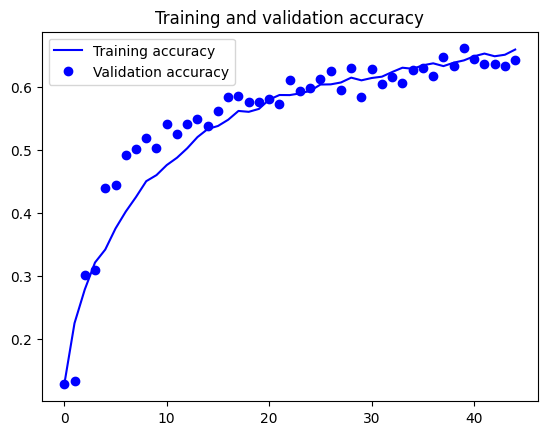

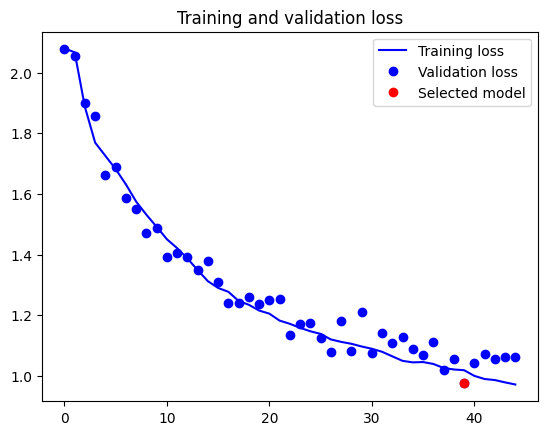

Lowest validation loss has been reached at epoch 39 with validation accuracy of 0.661


In [ ]:
model_name = "depthwise_separable_conv_deeper"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 175ms/step - loss: 0.9322 - accuracy: 0.6765
Test accuracy: 0.677, test loss: 0.932
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1568    0.8503    0.2648       147
           1     0.9653    0.6511    0.7777      1112
           2     0.8106    0.3702    0.5083       289
           3     0.3492    0.2245    0.2733        98
           4     0.6223    0.7091    0.6629       165
           5     0.6920    0.6007    0.6431       288
           6     0.6190    0.2977    0.4021       131
           7     0.6471    0.5612    0.6011        98

    accuracy                         0.5851      2328
   macro avg     0.6078    0.5331    0.5167      2328
weighted avg     0.7781    0.5851    0.6373      2328



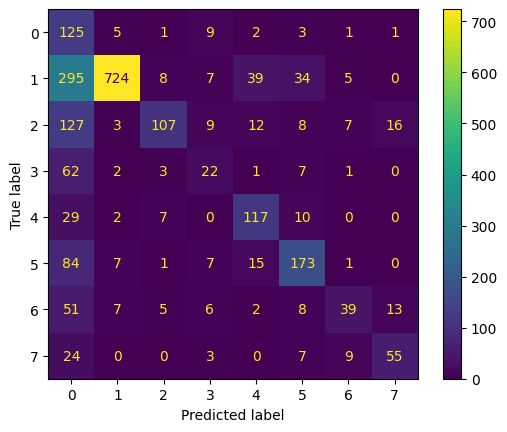

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

By slightly increasing the number of parameters and therefore the complexity of the model, the results are improved for both the validation set and the test set, in terms of accuracy and validation loss.



#Hyperparameter tuning

## Setup

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

my_dir = "/content/drive/My Drive/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [ ]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp1 = hp.Float('dropout_rate1', min_value = 0, max_value = 0.5)
  dropout_rate_hp2 = hp.Float('dropout_rate2', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = layers.SeparableConv2D(filters=32, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=4)(x)
  x = layers.SeparableConv2D(filters=64, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=128, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.SeparableConv2D(filters=256, padding='same', kernel_size=3, depth_multiplier=2, activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate_hp1)(x)
  x = layers.Dense(hp_units1, activation='relu')(x)
  x = layers.Dense(hp_units2, activation='relu')(x)
  x = layers.Dropout(dropout_rate_hp2)(x)
  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='depthwise_serable_conv_hptuning')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [ ]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=25,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perform search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, \
        The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}, \
        The optimal number of dropouts in the first layer is {best_hps.get('dropout_rate1')}, \
        The optimal number of dropouts in the second layer is {best_hps.get('dropout_rate2')}, \
        The optimal activation functionis {best_hps.get('activation_function')}, \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 384,         The optimal number of units in the second densely-connected layer is 32,         The optimal number of dropouts in the first layer is 0.27979051211721023,         The optimal number of dropouts in the second layer is 0.03270814857365706,         The optimal activation functionis relu,         the optimal learning rate for the optimizer is 0.001.


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/My Drive/tuner/logs/0503-1633/model_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0025 summary
Hyperparameters:
activation_function: relu
units1: 384
units2: 32
learning_rate: 0.001
dropout_rate1: 0.27979051211721023
dropout_rate2: 0.03270814857365706
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.725397527217865

Trial 0016 summary
Hyperparameters:
activation_function: relu
units1: 448
units2: 192
learning_rate: 0.001
dropout_rate1: 0.2914967718274412
dropout_rate2: 0.20220595272954967
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.7198109030723572

Trial 0024 summary
Hyperparameters:
activation_function: relu
units1: 96
units2: 352
learning_rate: 0.001
dropout_rate1: 0.4094440721995523
dropout_rate2: 0.3083232258985828
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/t

## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
55/55 [==============================] - 22s 305ms/step - loss: 1.9742 - accuracy: 0.2045 - val_loss: 1.7378 - val_accuracy: 0.2540
Epoch 2/50
55/55 [==============================] - 18s 303ms/step - loss: 1.7156 - accuracy: 0.3426 - val_loss: 1.7105 - val_accuracy: 0.3687
Epoch 3/50
55/55 [==============================] - 23s 409ms/step - loss: 1.5936 - accuracy: 0.4031 - val_loss: 1.6542 - val_accuracy: 0.4125
Epoch 4/50
55/55 [==============================] - 17s 286ms/step - loss: 1.4649 - accuracy: 0.4621 - val_loss: 1.4428 - val_accuracy: 0.4895
Epoch 5/50
55/55 [==============================] - 17s 296ms/step - loss: 1.3438 - accuracy: 0.5125 - val_loss: 1.2541 - val_accuracy: 0.5690
Epoch 6/50
55/55 [==============================] - 17s 286ms/step - loss: 1.2452 - accuracy: 0.5518 - val_loss: 1.2894 - val_accuracy: 0.5471
Epoch 7/50
55/55 [==============================] - 16s 279ms/step - loss: 1.1647 - accuracy: 0.5817 - val_loss: 1.2915 - val_accuracy: 0.5621

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

Epoch 1/20
55/55 [==============================] - 22s 301ms/step - loss: 1.9970 - accuracy: 0.1969 - val_loss: 1.8414 - val_accuracy: 0.3580
Epoch 2/20
55/55 [==============================] - 17s 286ms/step - loss: 1.6983 - accuracy: 0.3580 - val_loss: 1.6331 - val_accuracy: 0.4272
Epoch 3/20
55/55 [==============================] - 17s 292ms/step - loss: 1.5324 - accuracy: 0.4347 - val_loss: 1.4684 - val_accuracy: 0.5312
Epoch 4/20
55/55 [==============================] - 17s 284ms/step - loss: 1.3834 - accuracy: 0.5036 - val_loss: 1.4060 - val_accuracy: 0.5157
Epoch 5/20
55/55 [==============================] - 18s 299ms/step - loss: 1.2505 - accuracy: 0.5531 - val_loss: 1.3017 - val_accuracy: 0.5483
Epoch 6/20
55/55 [==============================] - 16s 282ms/step - loss: 1.1814 - accuracy: 0.5857 - val_loss: 1.1249 - val_accuracy: 0.6055
Epoch 7/20
55/55 [==============================] - 17s 285ms/step - loss: 1.0965 - accuracy: 0.6189 - val_loss: 1.0938 - val_accuracy: 0.6188

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

19/19 [==============================] - 5s 244ms/step - loss: 0.8619 - accuracy: 0.7075
[test loss, test accuracy]: [0.8619039058685303, 0.7074742317199707]
